In [3]:
!pip install gradio==4.26.0 pillow torchvision torch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import gradio as gr

In [2]:
# Preprocess: convert image to tensor
def image_to_tensor(img_path, size=512):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Postprocess: convert tensor to image
def tensor_to_image(tensor):
    image = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

In [4]:
def neural_style_transfer(content_img, style_img, steps=200, style_weight=1e6, content_weight=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    content = load_image(content_img).to(device)
    style = load_image(style_img).to(device)

    vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

    layers = {
        "0": "conv1_1",
        "5": "conv2_1",
        "10": "conv3_1",
        "19": "conv4_1",
        "21": "conv4_2",
        "28": "conv5_1"
    }

    content_features = {}
    style_features = {}
    x = content.clone()

    for name, layer in vgg._modules.items():
        content = layer(content)
        style = layer(style)

        if name in layers:
            if layers[name] == "conv4_2":
                content_features[layers[name]] = content
            else:
                style_features[layers[name]] = style

    target = x.clone().requires_grad_(True).to(device)
    optimizer = optim.Adam([target], lr=0.02)

    for _ in range(steps):
        target_features = {}
        out = target
        for name, layer in vgg._modules.items():
            out = layer(out)
            if name in layers:
                target_features[layers[name]] = out

        content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"])**2)

        style_loss = 0
        for layer in style_features:
            target_feature = target_features[layer]
            style_feature = style_features[layer]

            bs, ch, h, w = target_feature.shape
            target_gram = target_feature.view(ch, h*w) @ target_feature.view(ch, h*w).t()
            style_gram = style_feature.view(ch, h*w) @ style_feature.view(ch, h*w).t()

            style_loss += torch.mean((target_gram - style_gram)**2)

        loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    result = target.detach().cpu().squeeze()
    result = transforms.ToPILImage()(result)
    return result

In [4]:
!pip install gradio
import gradio as gr

In [5]:
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image

In [8]:
def load_image(img, max_size=512):
    if isinstance(img, str):
        img = Image.open(img).convert("RGB")

    size = min(max(img.size), max_size)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

In [28]:
def neural_style_transfer(content_img, style_img, steps=200, content_weight=1e4, style_weight=1e2):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    content = load_image(content_img).to(device)
    style = load_image(style_img).to(device)

    vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

    layers = {
        "0": "conv1_1",
        "5": "conv2_1",
        "10": "conv3_1",
        "19": "conv4_1",
        "21": "conv4_2",
        "28": "conv5_1"
    }

    # ---- extract content/style features (no grad) ----
    content_features = {}
    style_features = {}

    with torch.no_grad():
        x_c = content.clone()
        x_s = style.clone()
        for name, layer in vgg._modules.items():
            x_c = layer(x_c)
            x_s = layer(x_s)

            if name in layers:
                lname = layers[name]
                if lname == "conv4_2":
                    content_features[lname] = x_c
                else:
                    style_features[lname] = x_s

    # ---- target image with grad ----
    target = content.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([target], lr=0.02)

    for _ in range(steps):
        x_t = target
        target_features = {}

        for name, layer in vgg._modules.items():
            x_t = layer(x_t)
            if name in layers:
                target_features[layers[name]] = x_t

        # content loss
        content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"])**2)

        # style loss
        style_loss = 0
        for layer in style_features:
            t_feat = target_features[layer]
            s_feat = style_features[layer]

            bs, ch, h, w = t_feat.shape
            t_gram = (t_feat.view(ch, -1) @ t_feat.view(ch, -1).t())
            s_gram = (s_feat.view(ch, -1) @ s_feat.view(ch, -1).t())

            style_loss += torch.mean((t_gram - s_gram)**2)

        loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    result = target.detach().cpu().squeeze()
    return transforms.ToPILImage()(result)


In [44]:
from google.colab import files
uploaded = files.upload()

Saving nature1.1.jpg to nature1.1 (2).jpg
Saving nature4.jpg to nature4 (6).jpg


In [42]:
from PIL import Image

def resize_to_square(img_path, size=256):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((size, size))
    save_name = img_path.split('.')[0] + "_256.jpg"
    img.save(save_name)
    return save_name

content_img = resize_to_square("nature1.1.jpg", 256)
style_img = resize_to_square("nature4.jpg", 256)

content_img, style_img

('nature1_256.jpg', 'nature4_256.jpg')

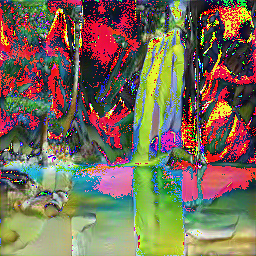

In [43]:
result = neural_style_transfer(content_img, style_img, steps=75)
result.save("output.jpg")
result